In [1]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.sql.types import ArrayType, StringType, BooleanType
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
import utils

%load_ext autoreload
%autoreload 2

LABEL = 'LOS'

spark = SparkSession.builder \
    .appName("Intensive Care Unit Data Analysis") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/08 19:57:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/06/08 19:57:44 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
# Read the datasets
df_admissions = spark.read.csv("datasets/ADMISSIONS.csv", header=True, inferSchema=True).drop("ROW_ID")
df_diagnoses = spark.read.csv("datasets/DIAGNOSES_ICD.csv", header=True, inferSchema=True).drop("ROW_ID")
df_icustays = spark.read.csv("datasets/ICUSTAYS.csv", header=True, inferSchema=True).drop("ROW_ID")
df_patients = spark.read.csv("datasets/PATIENTS.csv", header=True, inferSchema=True).drop("ROW_ID")
# df_chartevents = spark.read.csv("datasets/CHARTEVENTS.csv", header=True, inferSchema=True).drop("ROW_ID")

In [3]:
df = df_patients.join(df_admissions, df_patients["SUBJECT_ID"] == df_admissions["SUBJECT_ID"], how="left").drop(df_admissions["SUBJECT_ID"])
df = df.join(df_icustays, df["HADM_ID"] == df_icustays["HADM_ID"], how="left").drop(df_icustays["SUBJECT_ID"]).drop(df_icustays["HADM_ID"])
df = df.join(df_diagnoses, df["SUBJECT_ID"] == df_diagnoses["SUBJECT_ID"], how="left").drop(df_diagnoses["SUBJECT_ID"]).drop(df_diagnoses["HADM_ID"])

In [4]:
df.show()

+----------+------+-------------------+----+--------+-------+-----------+-------+-------------------+-------------------+---------+--------------+--------------------+------------------+---------+--------+-------------+--------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+----------+--------+--------------+-------------+------------+-----------+-------------------+-------------------+------+-------+---------+
|SUBJECT_ID|GENDER|                DOB| DOD|DOD_HOSP|DOD_SSN|EXPIRE_FLAG|HADM_ID|          ADMITTIME|          DISCHTIME|DEATHTIME|ADMISSION_TYPE|  ADMISSION_LOCATION|DISCHARGE_LOCATION|INSURANCE|LANGUAGE|     RELIGION|MARITAL_STATUS|           ETHNICITY|          EDREGTIME|          EDOUTTIME|           DIAGNOSIS|HOSPITAL_EXPIRE_FLAG|HAS_CHARTEVENTS_DATA|ICUSTAY_ID|DBSOURCE|FIRST_CAREUNIT|LAST_CAREUNIT|FIRST_WARDID|LAST_WARDID|             INTIME|            OUTTIME|   LOS|SEQ_NUM|ICD9_CODE|
+---

Check for missing values in the dataset.

In [5]:
utils.print_missing_value_counts(df)

-RECORD 0-----------------------
 SUBJECT_ID           | 0       
 GENDER               | 0       
 DOB                  | 0       
 DOD                  | 697342  
 DOD_HOSP             | 892628  
 DOD_SSN              | 839693  
 EXPIRE_FLAG          | 0       
 HADM_ID              | 0       
 ADMITTIME            | 0       
 DISCHTIME            | 0       
 DEATHTIME            | 1359709 
 ADMISSION_TYPE       | 0       
 ADMISSION_LOCATION   | 0       
 DISCHARGE_LOCATION   | 0       
 INSURANCE            | 0       
 LANGUAGE             | 379832  
 RELIGION             | 3721    
 MARITAL_STATUS       | 78080   
 ETHNICITY            | 0       
 EDREGTIME            | 476403  
 EDOUTTIME            | 476403  
 DIAGNOSIS            | 747     
 HOSPITAL_EXPIRE_FLAG | 0       
 HAS_CHARTEVENTS_DATA | 0       
 ICUSTAY_ID           | 31975   
 DBSOURCE             | 31975   
 FIRST_CAREUNIT       | 31975   
 LAST_CAREUNIT        | 31975   
 FIRST_WARDID         | 31975   
 LAST_WARD

# Feature Engineering

Let's create a column called 'AGE'

In [6]:
# Ensure 'DOB' and 'ADMITTIME' are in the correct date format if not already
df = df.withColumn('DOB', F.to_date('DOB'))
df = df.withColumn('ADMITTIME', F.to_date('ADMITTIME'))

# Create the 'AGE' column by calculating the difference in years between 'ADMITTIME' and 'DOB'
df = df.withColumn('AGE', F.expr("floor(months_between(ADMITTIME, DOB) / 12)"))

It only matters if the patient is dead or not, not the date of death, so we can drop the date of death columns. And we also drop other death-related columns.

In [7]:
df=df.drop("DOB").drop("DOD").drop("DOD_SSN").drop("EXPIRE_FLAG").drop("DEATHTIME")
df = df.withColumn("DOD_HOSP", F.when(F.col("DOD_HOSP").isNull(), 0).otherwise(1))
df = df.withColumnRenamed("DOD_HOSP", "DIED")
df = df.withColumnRenamed("ICD9_CODE","DISEASES_CODE")

Here we will drop the columns that are not useful for the analysis.

In [8]:
columns_to_remove = [
    "ADMITTIME", "DISCHTIME", "EDREGTIME", "EDOUTTIME", "HOSPITAL_EXPIRE_FLAG",
    "INTIME", "OUTTIME","LANGUAGE","DISCHARGE_LOCATION",
    "ICUSTAY_ID", "SEQ_NUM","HAS_CHARTEVENTS_DATA","DBSOURCE"
]

df = df.drop(*columns_to_remove)

The ethnicity column has too many unique values. We can group them into a few categories.

In [9]:
# Define the transformation using multiple chained when conditions
df = df.withColumn("ETHNICITY",
    F.when(F.col("ETHNICITY").isin('AMERICAN INDIAN/ALASKA NATIVE', 'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE'),
           'American Indian/Alaska Native')
    .when(F.col("ETHNICITY").isin('ASIAN', 'ASIAN - ASIAN INDIAN', 'ASIAN - CAMBODIAN', 'ASIAN - CHINESE', 'ASIAN - FILIPINO', 'ASIAN - JAPANESE', 'ASIAN - KOREAN', 'ASIAN - OTHER', 'ASIAN - THAI', 'ASIAN - VIETNAMESE'),
          'Asian')
    .when(F.col("ETHNICITY").isin('BLACK/AFRICAN', 'BLACK/AFRICAN AMERICAN', 'BLACK/CAPE VERDEAN', 'BLACK/HAITIAN'),
          'Black')
    .when(F.col("ETHNICITY").isin('HISPANIC OR LATINO', 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)', 'HISPANIC/LATINO - COLOMBIAN', 'HISPANIC/LATINO - CUBAN', 'HISPANIC/LATINO - DOMINICAN', 'HISPANIC/LATINO - GUATEMALAN', 'HISPANIC/LATINO - HONDURAN', 'HISPANIC/LATINO - MEXICAN', 'HISPANIC/LATINO - PUERTO RICAN', 'HISPANIC/LATINO - SALVADORAN'),
          'Hispanic/Latino')
    .when(F.col("ETHNICITY").isin('MIDDLE EASTERN'),
          'Middle Eastern')
    .when(F.col("ETHNICITY").isin('NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER'),
          'Pacific Islander')
    .when(F.col("ETHNICITY").isin('WHITE', 'WHITE - BRAZILIAN', 'WHITE - EASTERN EUROPEAN', 'WHITE - OTHER EUROPEAN', 'WHITE - RUSSIAN', 'PORTUGUESE'),
          'White')
    .when(F.col("ETHNICITY").isin('CARIBBEAN ISLAND', 'SOUTH AMERICAN'),
          'Caribbean/South American')
    .when(F.col("ETHNICITY").isin('MULTI RACE ETHNICITY'),
          'Multi-Race')
    .when(F.col("ETHNICITY").isin('OTHER'),
          'Other')
    .otherwise('NO DATA REGISTERED')
)

Now we can aggregate the data by primary keys and collect the remaining columns into lists.

In [10]:
# Define your primary key columns
primary_key_columns = ["SUBJECT_ID", "HADM_ID"]

# Identify the remaining columns to be grouped
remaining_columns = [col for col in df.columns if col not in primary_key_columns]

# Group by the primary key columns and aggregate the remaining columns into lists
df = df.groupBy(primary_key_columns).agg(*(F.collect_list(col).alias(col) for col in remaining_columns))



Now we can transform the columns that contain lists of values. If all values in the list are the same, we can replace the list with a single value. If the list is empty, we can replace it with a default value.

In [11]:
df.show()

+----------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|SUBJECT_ID|HADM_ID|              GENDER|                DIED|      ADMISSION_TYPE|  ADMISSION_LOCATION|           INSURANCE|            RELIGION|      MARITAL_STATUS|           ETHNICITY|           DIAGNOSIS|      FIRST_CAREUNIT|       LAST_CAREUNIT|        FIRST_WARDID|         LAST_WARDID|                 LOS|       DISEASES_CODE|                 AGE|
+----------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------

In [12]:
replace_empty_list_udf = F.udf(utils.replace_empty_list, ArrayType(StringType()))
transform_list_udf = F.udf(utils.transform_list, ArrayType(StringType()))
handle_list_udf = F.udf(utils.handle_list, StringType())
empty_list_udf = F.udf(lambda col: col == [], BooleanType())

for column in df.columns:    
    if isinstance(df.schema[column].dataType, ArrayType):
        if df.filter(empty_list_udf(F.col(column))).count() > 0:
            df = df.withColumn(column, replace_empty_list_udf(F.col(column)))
            
        df = df.withColumn(column, transform_list_udf(F.col(column)))
        if len(set(df.select(column).first()[0])) == 1:
            df = df.withColumn(column, handle_list_udf(df[column]))

Check for missing values again.

In [13]:
utils.print_missing_value_counts(df)

-RECORD 0-----------------
 SUBJECT_ID         | 0   
 HADM_ID            | 0   
 GENDER             | 0   
 DIED               | 0   
 ADMISSION_TYPE     | 0   
 ADMISSION_LOCATION | 0   
 INSURANCE          | 0   
 RELIGION           | 0   
 MARITAL_STATUS     | 0   
 ETHNICITY          | 0   
 DIAGNOSIS          | 0   
 FIRST_CAREUNIT     | 0   
 LAST_CAREUNIT      | 0   
 FIRST_WARDID       | 0   
 LAST_WARDID        | 0   
 LOS                | 0   
 DISEASES_CODE      | 0   
 AGE                | 0   



In [14]:
df.show()

+----------+-------+------+----+--------------+--------------------+---------+-------------+--------------+------------------+--------------------+--------------+-------------+------------+-----------+-------+--------------------+---+
|SUBJECT_ID|HADM_ID|GENDER|DIED|ADMISSION_TYPE|  ADMISSION_LOCATION|INSURANCE|     RELIGION|MARITAL_STATUS|         ETHNICITY|           DIAGNOSIS|FIRST_CAREUNIT|LAST_CAREUNIT|FIRST_WARDID|LAST_WARDID|    LOS|       DISEASES_CODE|AGE|
+----------+-------+------+----+--------------+--------------------+---------+-------------+--------------+------------------+--------------------+--------------+-------------+------------+-----------+-------+--------------------+---+
|        12| 112213|     M|   1|      ELECTIVE|PHYS REFERRAL/NOR...| Medicare|       JEWISH|       MARRIED|             White|PANCREATIC CANCER...|          SICU|         SICU|          23|         23| 7.6348|[1570, 57410, 997...| 72|
|        26| 197661|     M|   0|     EMERGENCY|TRANSFER FROM

Now let's analyze the diseases column. We can explode the column and calculate the mean length of stay for each disease code. Then we can rank the diseases for each patient and keep the top-ranked one.

In [15]:
# Explode the DISEASES_CODE column
exploded_df = df.withColumn("DISEASES_CODE", F.explode(F.col("DISEASES_CODE")))

# Calculate mean LOS for each disease code
disease_mean_los = exploded_df.groupBy("DISEASES_CODE").agg(F.mean("LOS").alias("mean_LOS"))

# Join the mean LOS back to the exploded dataframe
joined_df = exploded_df.join(disease_mean_los, on="DISEASES_CODE", how="left")

# Define window specification
window_spec = Window.partitionBy("SUBJECT_ID", "HADM_ID").orderBy(F.col("mean_LOS").desc())

# Rank disease codes for each patient and filter to keep the top-ranked one
most_influential_disease_df = joined_df.withColumn("rank", F.row_number().over(window_spec)).filter(F.col("rank") == 1)

# Select the relevant columns
result_df = most_influential_disease_df.select("SUBJECT_ID", "HADM_ID", "DISEASES_CODE")

# Ensure DISEASES_CODE is a string in both DataFrames
df = df.withColumn("DISEASES_CODE", F.col("DISEASES_CODE").cast("string"))
result_df = result_df.withColumn("DISEASES_CODE", F.col("DISEASES_CODE").cast("string"))

# Drop the DISEASES_CODE column from df before joining
df = df.drop("DISEASES_CODE")

# Join df with result_df on SUBJECT_ID and HADM_ID
updated_df = df.join(result_df, on=['SUBJECT_ID', 'HADM_ID'], how='left')

# Add the updated DISEASES_CODE column from result_df
df = updated_df.withColumn(
    "DISEASES_CODE",
    F.coalesce(result_df["DISEASES_CODE"], F.col("DISEASES_CODE"))
)

df = df.withColumnRenamed("DISEASES_CODE", "MOST_IMPORTANT_DISEASE_CODE")

In [16]:
# Show the updated DataFrame
df.show()

+----------+-------+------+----+--------------+--------------------+---------+-----------------+--------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---+---------------------------+
|SUBJECT_ID|HADM_ID|GENDER|DIED|ADMISSION_TYPE|  ADMISSION_LOCATION|INSURANCE|         RELIGION|MARITAL_STATUS|         ETHNICITY|           DIAGNOSIS|      FIRST_CAREUNIT|       LAST_CAREUNIT|        FIRST_WARDID|         LAST_WARDID|                 LOS|AGE|MOST_IMPORTANT_DISEASE_CODE|
+----------+-------+------+----+--------------+--------------------+---------+-----------------+--------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---+---------------------------+
|        19| 109235|     M|   0|     EMERGENCY|EMERGENCY ROOM ADMIT| Medicare|     UNOBTAINABLE|       UNKNOWN|             White|   

# Graphical Analysis

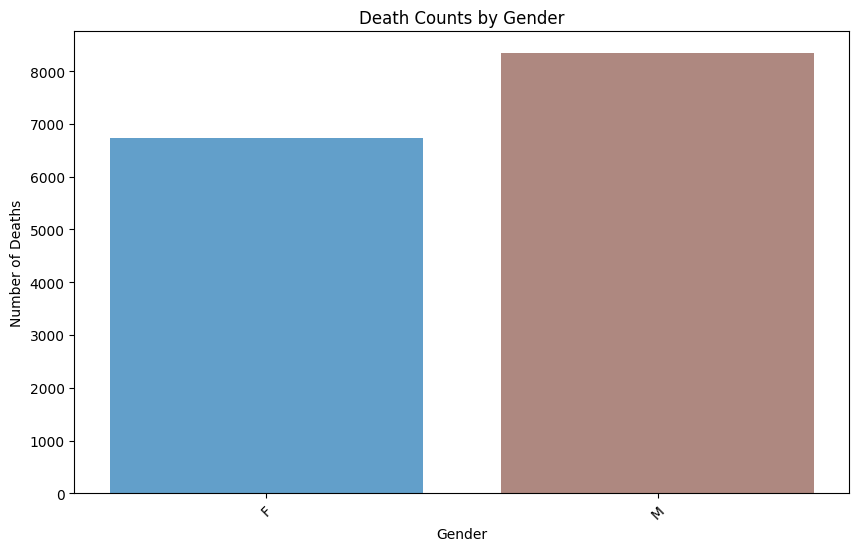

In [17]:
# Assuming `df` is your PySpark DataFrame
df = df.withColumn("DIED", df["DIED"].cast("integer"))

# Plotting death counts by gender
utils.plot_graph(df, 'GENDER', 'DIED', F.sum, 'Death Counts by Gender', 'Gender', 'Number of Deaths')

## Unique Value Count of marital status

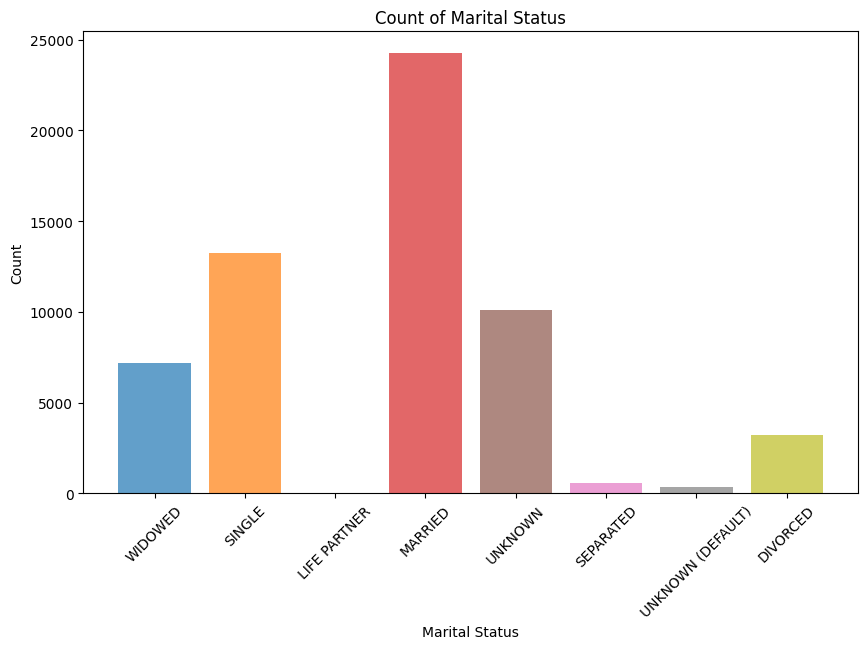

In [18]:
utils.plot_graph(df, 'MARITAL_STATUS', 'MARITAL_STATUS', F.count, 'Count of Marital Status', 'Marital Status', 'Count')

## Unique Value Count of Admission Types

In [ ]:
utils.plot_graph(df, 'ADMISSION_TYPE', 'ADMISSION_TYPE', F.count, 'Count of Admission Types', 'Admission Type', 'Count')

## Distribution of Lethality by Religion

The 1º and 2º deadliest religions are not shown in the graph because they are outliers.

In [ ]:
# Calculate death rate per religion
death_rate_per_religion = df.groupBy('RELIGION')\
    .agg(
        F.sum('DIED').alias('Deaths'), 
        F.count('DIED').alias('Total')
    )\
    .withColumn('Death Rate', (F.col('Deaths') / F.col('Total')) * 100)\
    .orderBy(F.col('Death Rate').desc())

religions = death_rate_per_religion.rdd.zipWithIndex().filter(lambda x: x[1] in [2,3,4,5,6,7]).map(lambda x: x[0]).toDF()

utils.plot_graph(religions, 'RELIGION', 'Death Rate', F.first, 'Death Rates for Religions Ranked', 'Religion', 'Death Rate (%)')

## Distribution of Lethality by Ethnicity

In [ ]:
filtered_df = df.filter(df['ETHNICITY'] != 'NO DATA REGISTERED')

# Calculate death rate per ethnicity
death_rate_per_ethnicity = filtered_df.groupBy('ETHNICITY')\
    .agg(
        F.sum('DIED').alias('Deaths'), 
        F.count('DIED').alias('Total')
    )\
    .withColumn('Death Rate', (F.col('Deaths') / F.col('Total')) * 100)\
    .orderBy(F.col('Death Rate').desc())\
    .limit(5)

utils.plot_graph(death_rate_per_ethnicity, 'ETHNICITY', 'Death Rate', F.first, 'Top 5 Deadliest Ethnicities by Death Rate', 'Ethnicity', 'Death Rate (%)')

## Distribution of Length of Stay by Age

# Pre processing

Let's convert the categorical columns to numerical columns. And let's get the categorical and numerical columns names.

In [ ]:
all_columns = df.columns
feature_columns = [col for col in all_columns if col not in ['SUBJECT_ID', LABEL]]

# Manually specified categorical and numerical features
categorical_features = ['ADMISSION_TYPE', 'ADMISSION_LOCATION', 'INSURANCE', 'RELIGION',
                        'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'MOST_IMPORTANT_DISEASE_CODE']
numerical_features = [col for col in feature_columns if col not in categorical_features and col not in ['SUBJECT_ID', LABEL]]

# Transform the 'M' and 'F' values to 0 and 1 respectively
df = df.withColumn("GENDER", F.when(F.col("GENDER") == "M", 0).otherwise(1))
# Cast string numerical features to float
df = df.withColumn("AGE", F.col("AGE").cast("float"))
df = df.withColumn("FIRST_WARDID", F.col("FIRST_WARDID").cast("float"))
df = df.withColumn("LAST_WARDID", F.col("LAST_WARDID").cast("float"))
df = df.withColumn("LOS", F.col("LOS").cast("float"))

df.show()

In [ ]:
# Stages in the pipeline
stages = []

# Indexing and encoding categorical features
for categoricalCol in categorical_features:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index", handleInvalid="keep")
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "ClassVec"])
    stages += [stringIndexer, encoder]

# Assemble all the features along with the encoded categorical features
assemblerInputs = [c + "ClassVec" for c in categorical_features] + numerical_features
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features", handleInvalid="keep")
stages += [assembler]

# Pipeline: This will ensure all stages are applied in sequence
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(df)
df_transformed = pipelineModel.transform(df)

Here we are making sure that there isn't simultaneously a patient in the test set and train set.

In [ ]:
# Assume subject_ids have been collected as before
subject_ids = [row['SUBJECT_ID'] for row in df_transformed.select("SUBJECT_ID").distinct().collect()]
split_index = int(len(subject_ids) * 0.8)

train_ids = set(subject_ids[:split_index])
test_ids = set(subject_ids[split_index:])

# Directly filter the DataFrame using the list
train_df = df_transformed.filter(F.col("SUBJECT_ID").isin(train_ids))
test_df = df_transformed.filter(F.col("SUBJECT_ID").isin(test_ids))

# Ensure that both train and test data have non-null labels
train_df = train_df.filter(train_df[LABEL].isNotNull())
test_df = test_df.filter(test_df[LABEL].isNotNull())

# Split the test_df into features and labels
X_test = test_df.drop(LABEL)
y_test = test_df.select(LABEL)

# Prediction

## Linear Regression

In [ ]:
param = {
    'maxIter': 10,
    'regParam': 0.3,
    'elasticNetParam': 0.8
}

# Define and fit the Linear Regression model on the training set
lr = LinearRegression(featuresCol='features', labelCol=LABEL, **param)
lr_model = lr.fit(train_df)

In [ ]:
y_pred = lr_model.transform(X_test)

# Calculate the mean residuals
print(f"Linear Regression - Mean of differences between predicted and actual values: {utils.mean_residuals(y_pred, y_test)}.")

# Calculate the accuracy of the model
print(f"Linear Regression - Accuracy: {utils.calculate_accuracy(y_pred, y_test)}%.")


## Random Forest Regression

In [ ]:
param = {
    'maxDepth': 5,
    'maxBins': 32,
    'minInstancesPerNode': 1,
    'minInfoGain': 0.0,
    'maxMemoryInMB': 256,
    'cacheNodeIds': False,
    'checkpointInterval': 10,
    'impurity': 'variance',
    'featureSubsetStrategy': 'auto',
    'subsamplingRate': 1.0,
    'seed': None,
    'numTrees': 20,
}

# Define and fit the Random Forest model on the training set
rf = RandomForestRegressor(featuresCol='features', labelCol=LABEL, **param)
rf_model = rf.fit(train_df)

In [ ]:
y_pred = rf_model.transform(X_test)

# Calculate the mean residuals
print(f"Random Forest Regression - Mean of differences between predicted and actual values: {utils.mean_residuals(y_pred,y_test)}.")

# Calculate the accuracy of the model
print(f"Random Forest Regression - Accuracy: {utils.calculate_accuracy(y_pred, y_test)}%.")